In [45]:
from scipy import integrate
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle
def unPackRawFile(raw_path):
    """


    
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
   
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

def getPos(path_LOS,linenumber=8):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=8):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def calculate_gamma(temperature,density,xHI,scale):
    '''Gamma = R(T)*ne/xHI, R(T) = 4.3e-13 * (T/1e4K)^{-0.7), ne = 0.82*nb.
    '''
    omega_b = 0.0479; h = 0.6814
    mean_nb = 1.123e-5/scale**3*omega_b*h**2
    nb = np.multiply(density ,mean_nb); ne = 0.82*nb
    R_T = 4.3e-13 * (np.divide(temperature,1e4))**(-0.7)
    gamma = R_T * ne / xHI
    
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    
    neutral_fraction = []
    real_lyman = []
    gamma = []
    HI = []
    gas_den = []
    real_area_under = []
    which = 0
    for i in range(51):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance_cm = distance *0.1453*3.086e24 /0.68
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        print(position[0]/512*40, position[1]/512*40,position[2]/512*40)
        print(direction)
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k+1
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                peak_gas = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                            peak_gas = gas_density[k]
                            peak_gamma = calculate_gamma(temp[k],gas_density[k],peak_fraction,0.1452)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    real_distance = [(position[0]/256*40+peak_distance*direction[0])%40, (position[1]/256*40+peak_distance*direction[1])%40,(position[2]/256*40+peak_distance*direction[2])%40]
                    print(real_distance)
                    distance_graph = []
                    HI_graph = [ ]
                    distance_real = []
                    for i in range(len(distance)):
                        if(distance[left_bases]<=distance[i]<= distance[right_bases]):
                            distance_graph.append(distance_cm[i])
                            HI_graph.append(HI_density[i])
                            distance_real.append(distance[i])
                    y_int = integrate.cumtrapz(HI_graph,distance_graph,initial = 0)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(y_int[-1] >= (10**16)and y_int[-1]  <= (10**22)):
                        real_lyman.append([y_int,real_distance])
                        real_area_under.append(y_int)
                        neutral_fraction.append(peak_fraction)
                        HI.append(peak_HI)
                        gamma.append(peak_gamma)
                        gas_den.append(peak_gas)
                        which = [i,distance[left_bases], distance[right_bases], peak_distance]
    return real_lyman,neutral_fraction,gamma,HI,gas_den,which,real_area_under

In [46]:
import numpy as np
real_lyman,neutral_fraction,gamma,HI,gas_den,which,real_area_under  = lyman_identification()

20.520312500000003 35.702421875 21.809609375
[0.90854472 0.26859326 0.32000648]
6.4972421874999995 10.13859375 29.148515625
[-0.72362636 -0.68210924 -0.105318  ]
33.006171875 2.4850078125 34.649765625
[-0.8921208  -0.45075957 -0.0305989 ]
12.91484375 14.195546875 14.441328124999998
[-0.98377725  0.17839011  0.01895519]
29.92484375 18.85234375 24.189140625
[0.90164668 0.43198752 0.02049489]
30.307890625 21.556953125 18.13234375
[-0.91755718  0.39756977  0.0052063 ]
28.07359375 26.710781250000004 14.862265625
[ 0.55673021 -0.76581304 -0.32184135]
[31.768807020925543, 21.627812049061266, 12.726091941241126]
22.101484375 15.231328125000001 22.81234375
[0.34819571 0.70954251 0.61262483]
32.590937499999995 20.728359374999997 6.1692656249999995
[-0.96718066  0.24372184 -0.07184173]
22.23953125 26.565390625 30.045
[-0.69240645  0.58210912  0.42628896]
2.9181953125 39.35453125 11.809453125000001
[-0.54198517 -0.10088447  0.83431073]
[1.9931675386298338, 39.1823476924095, 13.233404622651618]
13.

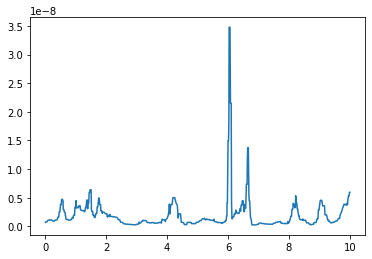

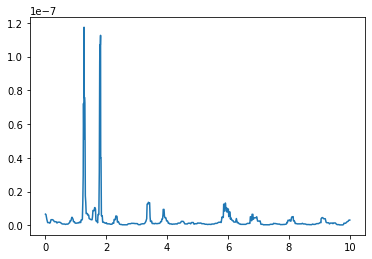

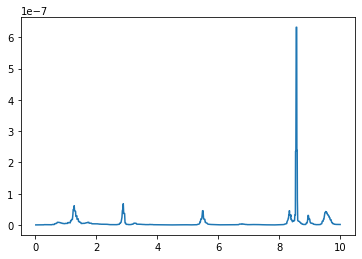

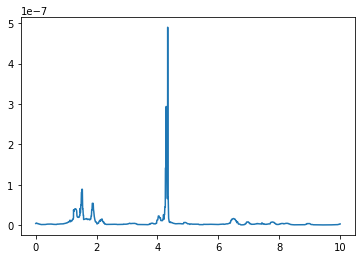

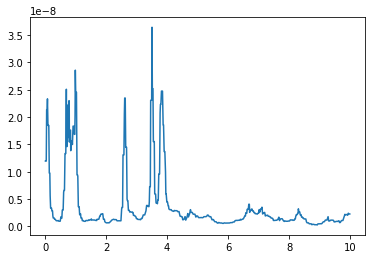

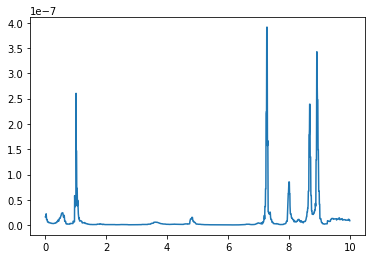

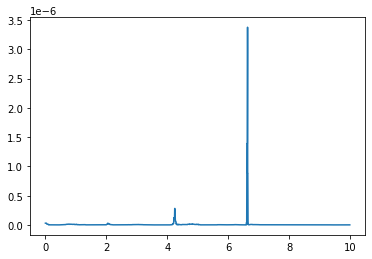

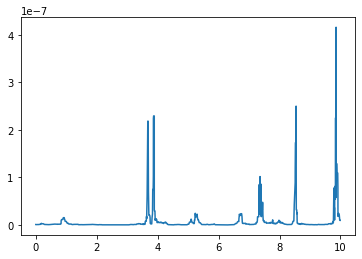

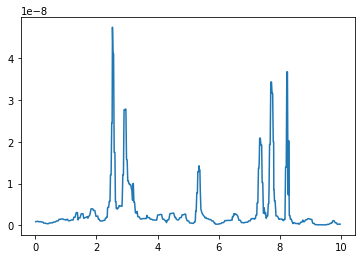

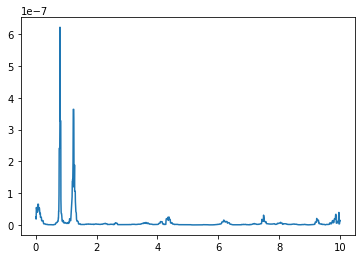

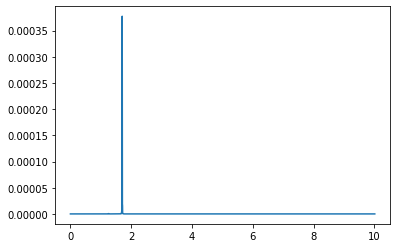

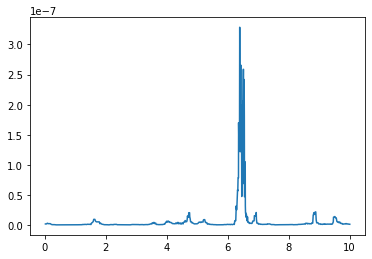

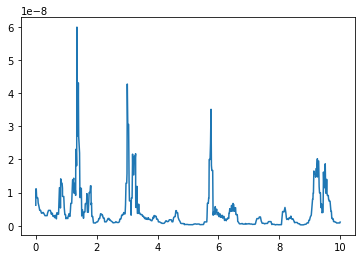

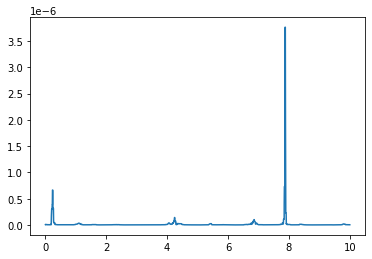

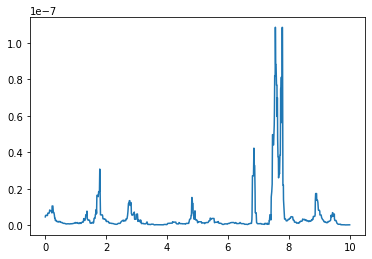

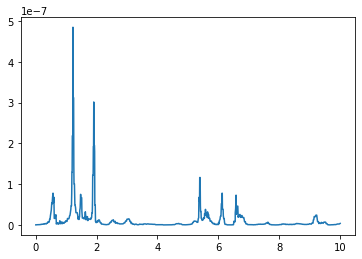

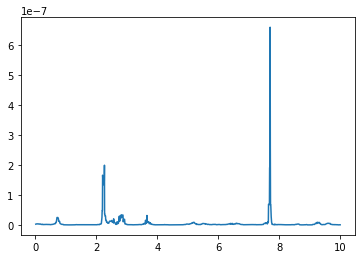

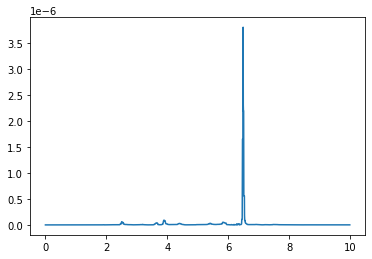

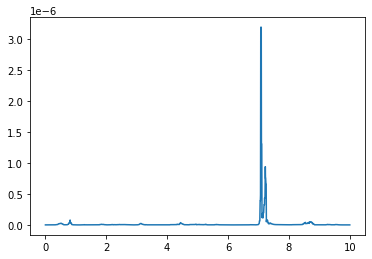

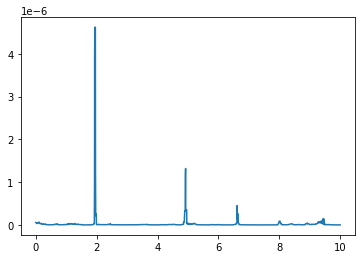

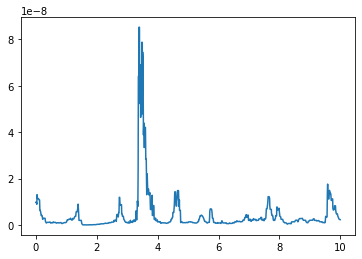

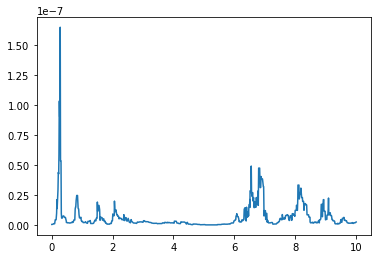

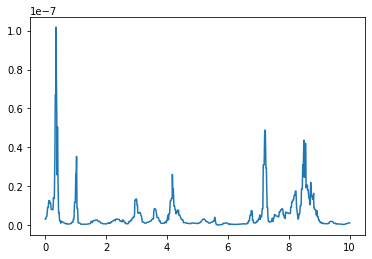

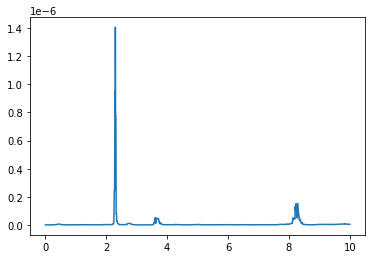

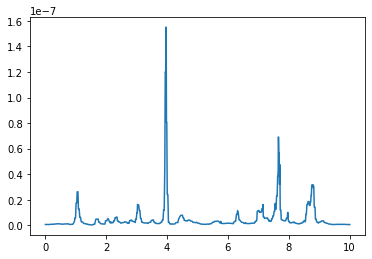

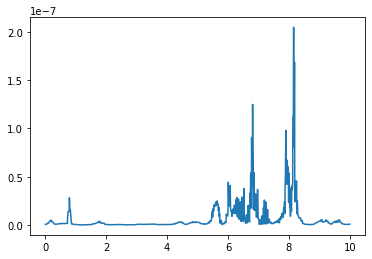

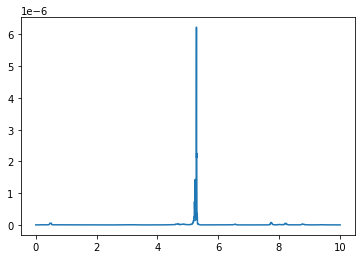

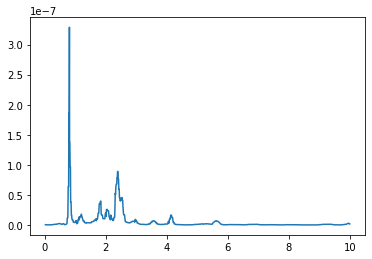

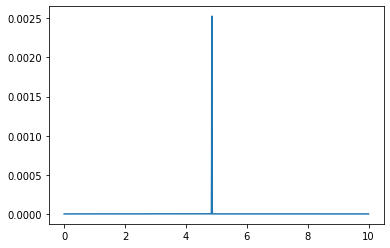

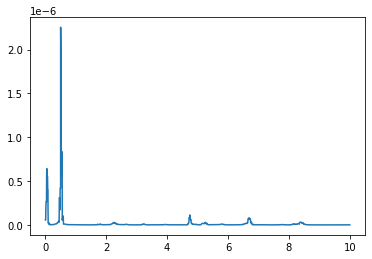

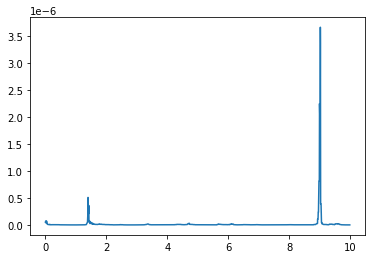

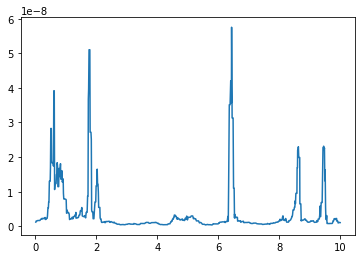

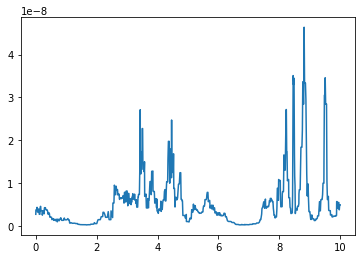

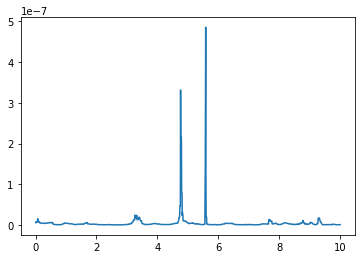

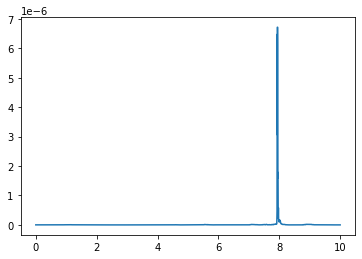

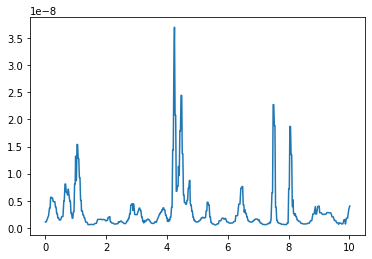

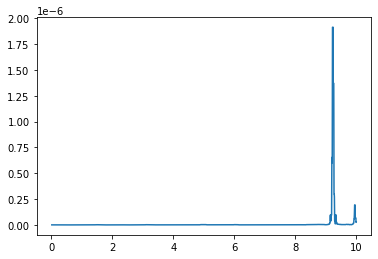

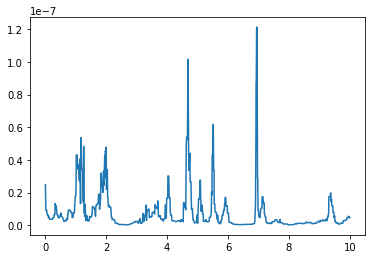

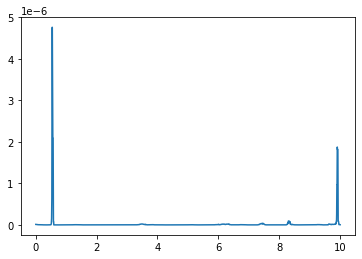

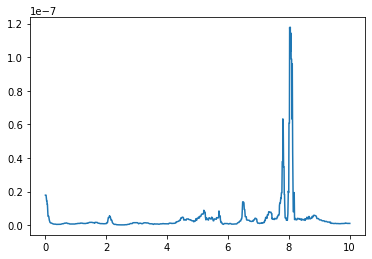

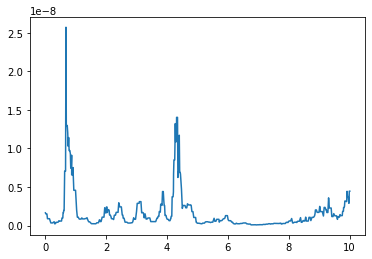

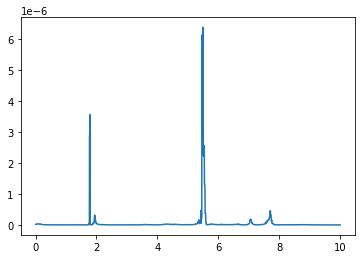

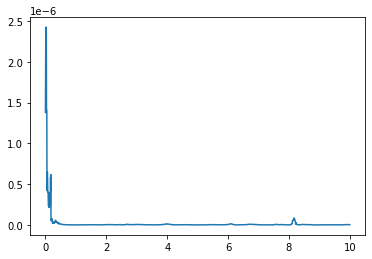

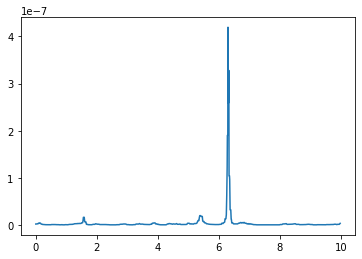

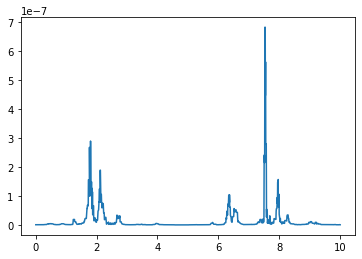

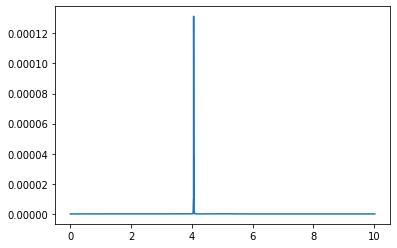

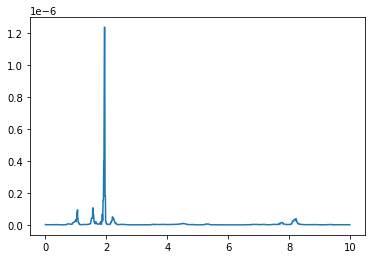

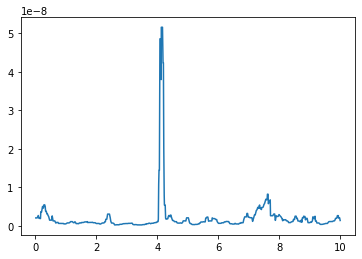

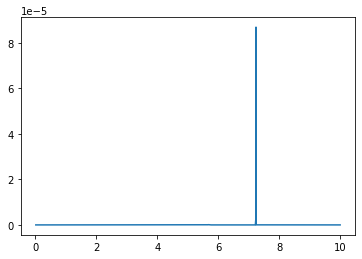

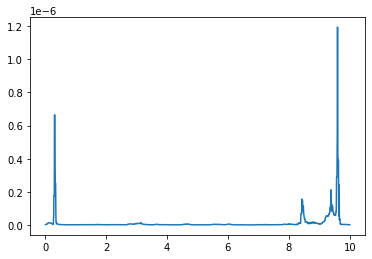

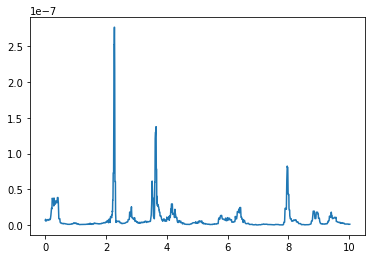

In [27]:
for i in range(0,51):
    raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
    distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
    plt.plot(distance,HI_density)
    plt.show()

In [42]:
for i in real_lyman:
    print(i[0][-1])

2.525631050903422e+18
2.0396641338510656e+16
2.6085006942453216e+16
3.5067255122910788e+16
7.416894156523958e+16
3.0134070471872056e+16
2.8070810224499573e+19
4.695790396706394e+16
6.79676804036793e+16
8.689706517970434e+16
3.373782421944168e+16
2.0025530840778214e+17
2.457323720572353e+16
6.412032179024448e+17
4.7331922113743706e+17
